# Predictive model : 


<a id="home"></a>

### Table of contents
- [a) Importing the necessary library and data](#library)
- [b)Choose of features](#features)
    - [i) Transform categorical feature to numerical ](#dummies)
    - [i) Inspect potential correlation ](#corr)
- [c) Knn - model](#knn)
    - [i) Find the bast value of k](#for_k)
	- [ii) Look at result for a chosen k](#selected_k)
- [d) Change features](#2nd_model)

<a id="library"></a>

## a) Importing the necessary library and data

In [3]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sea

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

import matplotlib.gridspec as gridspec

In [4]:
NSW_crash = pd.read_csv('NSW_crash_clean.csv', index_col=0)
NSW_crash.head()

,Crash ID,Degree of crash,Degree of crash - detailed,Year of crash,Month of crash,Day of week of crash,Latitude,Longitude,LGA,Urbanisation,Conurbation 1,Surface condition,Weather,Speed limit,Road classification (admin),hour,Injuries,Date of crash
0,1088679,Fatal,Fatal,2016,January,Saturday,-32.830075,148.293512,Parkes,Country non-urban,Rest of NSW - Rural,Dry,Fine,100,Local,1,1,2016-01-01
1,1088682,Fatal,Fatal,2016,January,Monday,-35.800954,150.132066,Eurobodalla,Country non-urban,Rest of NSW - Rural,Wet,Raining,100,State,21,1,2016-01-01
2,1088829,Non-casualty (towaway),Non-casualty (towaway),2016,January,Friday,-34.031609,151.067157,Sutherland,Sydney metro. area,Syd-Newc-Woll Gtr conurbation,Dry,Fine,70,State,13,0,2016-01-01
3,1088867,Non-casualty (towaway),Non-casualty (towaway),2016,January,Friday,-33.847025,150.967695,Cumberland,Sydney metro. area,Syd-Newc-Woll Gtr conurbation,Dry,Fine,50,Local,13,0,2016-01-01
4,1088880,Non-casualty (towaway),Non-casualty (towaway),2016,January,Friday,-33.873753,151.212595,Sydney,Sydney metro. area,Syd-Newc-Woll Gtr conurbation,Wet,Fine,50,Regional,17,0,2016-01-01


<a id="features"></a>


## b)Choose of features
    

After some analysis in TABLEAU and Python during cleaning, here is our conclusions for knn-model : 

###### TARGET

The percentage of fatality is too low to be optimally considered in a knn-model. I cannot use 'Degree of crash' or 'Degree of crash - detailed' as a target for my model
 
My target is now Injuries, a bianry column that is equal to 0 when the crashes didn't lead to injury or fatality, else 1. 

###### FEATURES

By looking at the percentage of crashes that cause injury, I can estimate the impact of a features on my target. A feature was estimated important if the range of percentage was greater than 5%. 

* Time of crash : I keeped only the hour of the day. 
* Location : Urbanisation and Conurbation 1 doesn't have great impact to the rate injury. Road classification and Speed Limit, that can be deduced from location with a map and/or GPS have good impact. Particularly for speed limit, where the injury's rate goes from 63% on road limited at 110km/h to 87 on road limited at 30km/h
* Weather : Weather and surface condition of road have impact on rate injuries. (Surface condition needs to be given by a witness, but I assumed that Dry - Wet - Snow are easy enough category to trust the witness) 

Note : But for location, I want to see if we can use categorical values, but in case of it doesn't give a good predictive model, I can try by using directly Longitude and Latitude. 

In [5]:
NSW_crash.columns

Index(['Crash ID', 'Degree of crash', 'Degree of crash - detailed',
       'Year of crash', 'Month of crash', 'Day of week of crash', 'Latitude',
       'Longitude', 'LGA', 'Urbanisation', 'Conurbation 1',
       'Surface condition', 'Weather', 'Speed limit',
       'Road classification (admin)', 'hour', 'Injuries', 'Date of crash'],
      dtype='object')

C:\Users\ameli\AppData\Local\Temp\ipykernel_13676\2069013643.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(weather_corr, dtype=np.bool))


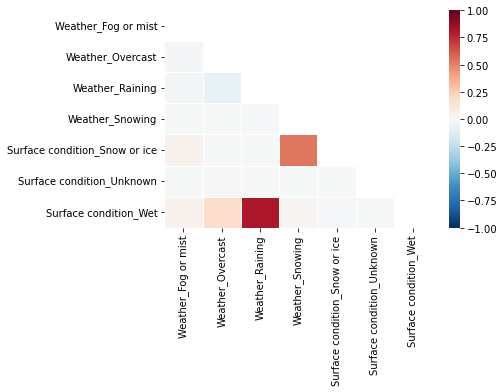

In [6]:
weather_columns = ['Weather', 'Surface condition' ]

weather_correlation = pd.DataFrame(index = range(NSW_crash.shape[0]))

# We transform categorical features into numerical features
for category in weather_columns : 
    dummies = pd.get_dummies(NSW_crash[category], prefix= category)
    reference_count = dummies.sum().max()
    dummies = dummies[dummies.columns[dummies.sum() != reference_count]]
    weather_correlation = pd.merge(weather_correlation, dummies, left_index= True, right_index=True)

    
# WE look at the correaltion    
weather_corr = weather_correlation.corr()

mask = np.triu(np.ones_like(weather_corr, dtype=np.bool))
sea.heatmap(weather_corr,annot=False, fmt=".1f", vmin=-1,
            vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");    
    

Surface condition is highly correlated with Weather (particularly Wet road with Raining, and snow on road with Snowing)
I decided to keep only the data about weather.

C:\Users\ameli\AppData\Local\Temp\ipykernel_13676\1718284367.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(location_corr, dtype=np.bool))


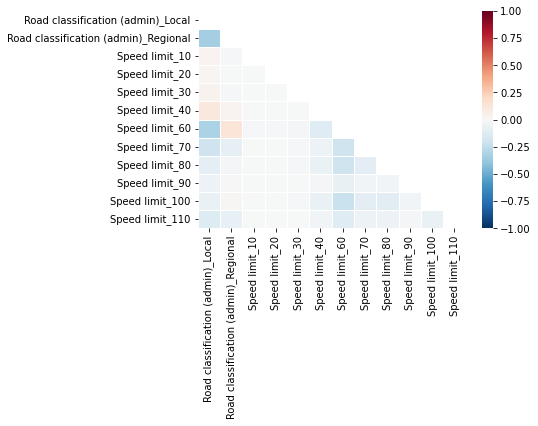

In [7]:
location_road_columns = ['Road classification (admin)', 'Speed limit' ]

location_correlation = pd.DataFrame(index = range(NSW_crash.shape[0]))

for category in location_road_columns : 
    dummies = pd.get_dummies(NSW_crash[category], prefix= category)
    reference_count = dummies.sum().max()
    dummies = dummies[dummies.columns[dummies.sum() != reference_count]]
    location_correlation = pd.merge(location_correlation, dummies, left_index= True, right_index=True)

    
    
location_corr = location_correlation.corr()

mask = np.triu(np.ones_like(location_corr, dtype=np.bool))
sea.heatmap(location_corr,annot=False, fmt=".1f", vmin=-1,
            vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");    

There is no correlation between these two features. 

Finally our features are : 

    * hour
    * Speed limit
    * Road classification
    * Weather

<a id="dummies"></a>
### i) Transform categorical feature to numerical 

Note : for quicker calculations, and better readability, some preliminary work was already made above. 


In [8]:
categorical = [ 'Road classification (admin)', 'Weather']
numerical = ['hour', 'Speed limit']
target = ['Injuries']

In [9]:
crash_model = NSW_crash[numerical]

for category in categorical : 
    dummies = pd.get_dummies(NSW_crash[category], prefix= category)
    reference_count = dummies.sum().max()
    # When we create a dummies, we have to delete a columns. Otherwise, one will be deduced from the others. 
    # I deleted the columns with the most number of accident that caused injury. 
    dummies = dummies[dummies.columns[dummies.sum() != reference_count]]
    crash_model = pd.merge(crash_model, dummies, left_index= True, right_index=True)
crash_model.head()

,hour,Speed limit,Road classification (admin)_Local,Road classification (admin)_Regional,Weather_Fog or mist,Weather_Overcast,Weather_Raining,Weather_Snowing
0,1,100,1,0,0,0,0,0
1,21,100,0,0,0,0,1,0
2,13,70,0,0,0,0,0,0
3,13,50,1,0,0,0,0,0
4,17,50,0,1,0,0,0,0


In [10]:
X = crash_model.copy()
y= NSW_crash[['Injuries']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

C:\Users\ameli\AppData\Local\Temp\ipykernel_13676\4057680536.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a, b = np.int(i/2), i%2
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


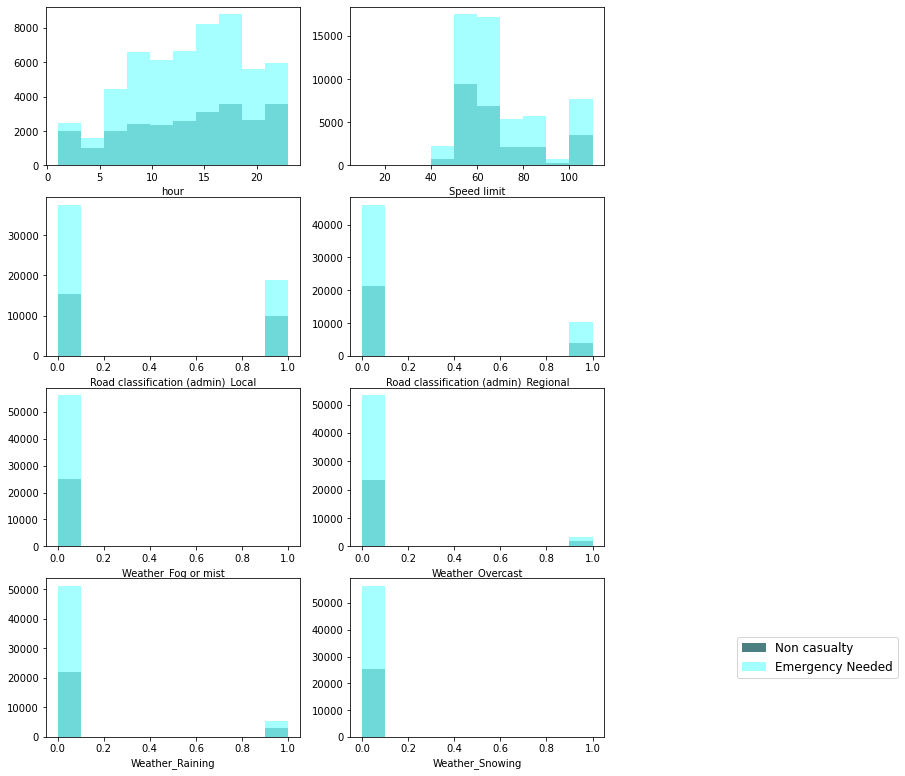

In [11]:
fig = plt.figure(figsize=(10,66))
gs = gridspec.GridSpec(nrows=19, ncols=2, figure=fig)

for i, c in enumerate(X.columns):
    a, b = np.int(i/2), i%2 
    ax = fig.add_subplot(gs[a,b])    
    sea.distplot(X_train.loc[y["Injuries"]==0,c], kde = False,
                 color = "#004a4d", hist_kws = dict(alpha=0.7),
                 bins=10, label='Non casualty', ax=ax);
    sea.distplot(X_train.loc[y["Injuries"]==1,c], kde = False,
                 color = "#7fffff", hist_kws = dict(alpha=0.7),
                 bins=10, label="Emergency Needed", ax=ax);

ax.legend(loc="center left", bbox_to_anchor=(1.5,0.5),
          prop={"size":12});

<a id="corr"></a>

### i) Inspect potential correlation


<class 'pandas.core.frame.DataFrame'>


C:\Users\ameli\AppData\Local\Temp\ipykernel_13676\890545531.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


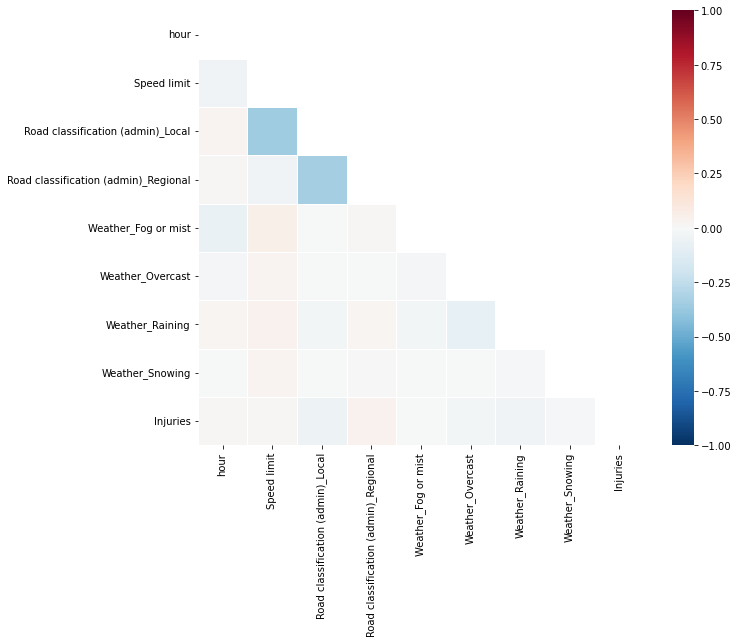

In [12]:
corr_matrix = pd.concat([X, y], axis=1).corr()
print(type(corr_matrix))
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=False, fmt=".1f", vmin=-1,
            vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

<a id="knn"></a>

## c) Knn - model

#### Baseline Model 

My baseline model is to put all the crashes under the most important category. In our case, basesline says that all accident lead to an injury. 

In [13]:
print(f'Our model accuracy is {y.sum()/y.count()}')

print(f'Our model error is {1-y.sum()/y.count()}')

Our model accuracy is Injuries    0.691723
dtype: float64
Our model error is Injuries    0.308277
dtype: float64


<a id='for_k'></a>

### i) Find the bast value of k


In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
k_range = list(range(1, 50,2))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector 

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [17]:
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

,training error,testing error
K,,
49,0.308277,0.308710
47,0.308277,0.308452
45,0.308277,0.308856
43,0.308277,0.308856
41,0.308277,0.309738


In [18]:
df['Baseline'] = (1-y.sum()/y.count()).Injuries

df.head()

,training error,testing error,Baseline
K,,,
49,0.308277,0.308710,0.308277
47,0.308277,0.308452,0.308277
45,0.308277,0.308856,0.308277
43,0.308277,0.308856,0.308277
41,0.308277,0.309738,0.308277


In [19]:
print(1-y.sum()/y.count())

Injuries    0.308277
dtype: float64


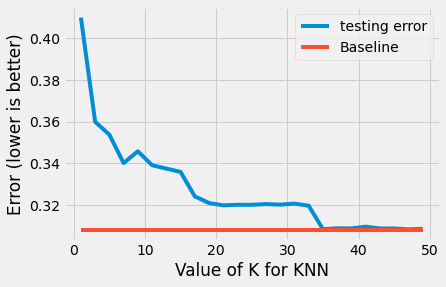

In [20]:

df.plot(y=['testing error', 'Baseline']);
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

<a id='selected_k'></a>

### ii) Look at result for a chosen k
35 is the first value of k that makes the model be at least as good as our baseline model. 

In [60]:
knn = KNeighborsClassifier(n_neighbors=35)
knn.fit(X_train, y_train)
    
# Calculate training error (error = 1 - accuracy).
y_pred_class = knn.predict(X)
training_accuracy = metrics.accuracy_score(y, y_pred_class)
print(training_accuracy)
# Calculate testing error.
y_pred_class = knn.predict(X_test)
testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(testing_accuracy)

X = crash_model.copy()
y= NSW_crash[['Injuries']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.6917227635482005
0.6901884435954891


In [61]:
print(classification_report(y_test, y_pred_class,target_names=['Non Casualty', 'Injuries']))


              precision    recall  f1-score   support

Non Casualty       0.48      0.08      0.14      8373
    Injuries       0.70      0.96      0.81     18850

    accuracy                           0.69     27223
   macro avg       0.59      0.52      0.48     27223
weighted avg       0.63      0.69      0.60     27223



In [62]:
dataset = pd.DataFrame({'Truth': y_test.Injuries, 'Predicted': y_pred_class}, columns=['Truth', 'Predicted'])
dataset['adHoc'] = 1
dataset.head()

,Truth,Predicted,adHoc
32857,1,1,1
104702,0,1,1
3605,1,0,1
2182,1,1,1
30947,1,1,1


In [63]:
predictive_table = pd.pivot_table(dataset, columns = ['Truth'], index = ['Predicted'], values = 'adHoc', aggfunc= 'count')
print(predictive_table)

Truth         0      1
Predicted             
0           681    742
1          7692  18108


<a id='2nd_model'></a>

## d) Change features

In [49]:
numerical = ['hour','Speed limit', 'Longitude', 'Latitude']
categorical = ['Weather']

crash_model = NSW_crash[numerical]

for category in categorical : 
    dummies = pd.get_dummies(NSW_crash[category], prefix= category)
    reference_count = dummies.sum().max()
    # When we create a dummies, we have to delete a columns. Otherwise, one will be deduced from the others. 
    # I deleted the columns with the most number of accident that caused injury. 
    dummies = dummies[dummies.columns[dummies.sum() != reference_count]]
    crash_model = pd.merge(crash_model, dummies, left_index= True, right_index=True)
crash_model.head()

target = ['Injuries']

In [50]:
X = crash_model.copy()
y= NSW_crash[['Injuries']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

C:\Users\ameli\AppData\Local\Temp\ipykernel_13676\4057680536.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a, b = np.int(i/2), i%2
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


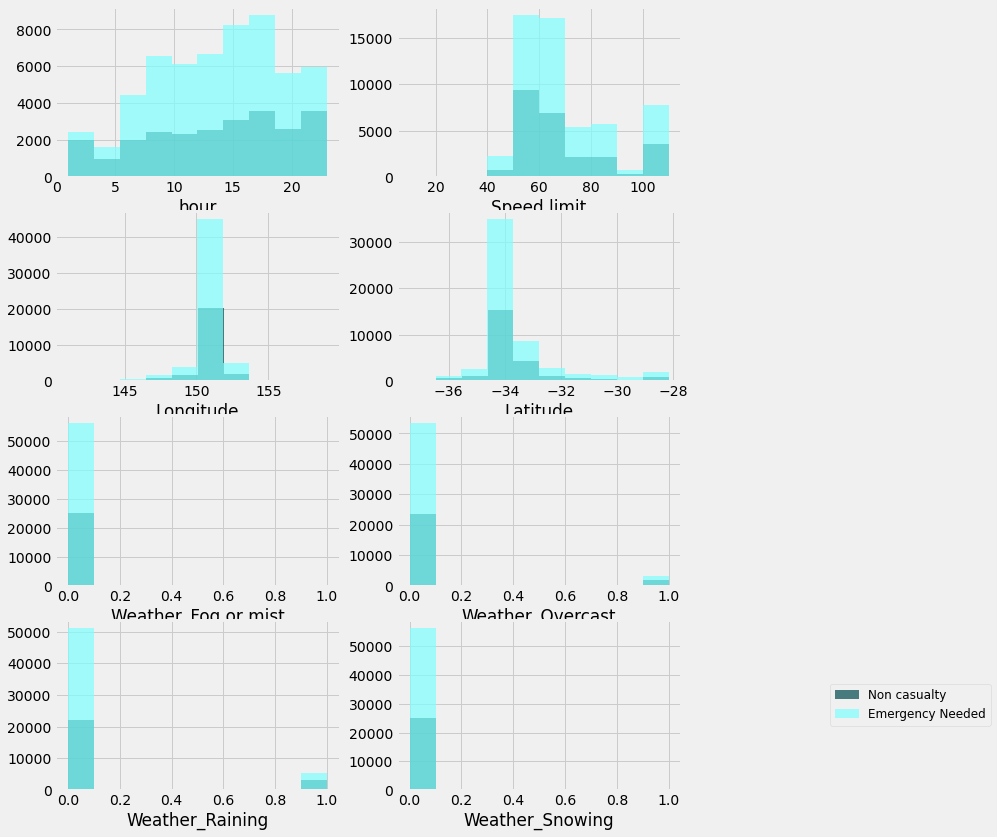

In [51]:
fig = plt.figure(figsize=(10,66))
gs = gridspec.GridSpec(nrows=19, ncols=2, figure=fig)

for i, c in enumerate(X.columns):
    a, b = np.int(i/2), i%2 
    ax = fig.add_subplot(gs[a,b])    
    sea.distplot(X_train.loc[y["Injuries"]==0,c], kde = False,
                 color = "#004a4d", hist_kws = dict(alpha=0.7),
                 bins=10, label='Non casualty', ax=ax);
    sea.distplot(X_train.loc[y["Injuries"]==1,c], kde = False,
                 color = "#7fffff", hist_kws = dict(alpha=0.7),
                 bins=10, label="Emergency Needed", ax=ax);

ax.legend(loc="center left", bbox_to_anchor=(1.5,0.5),
          prop={"size":12});

<class 'pandas.core.frame.DataFrame'>


C:\Users\ameli\AppData\Local\Temp\ipykernel_13676\890545531.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


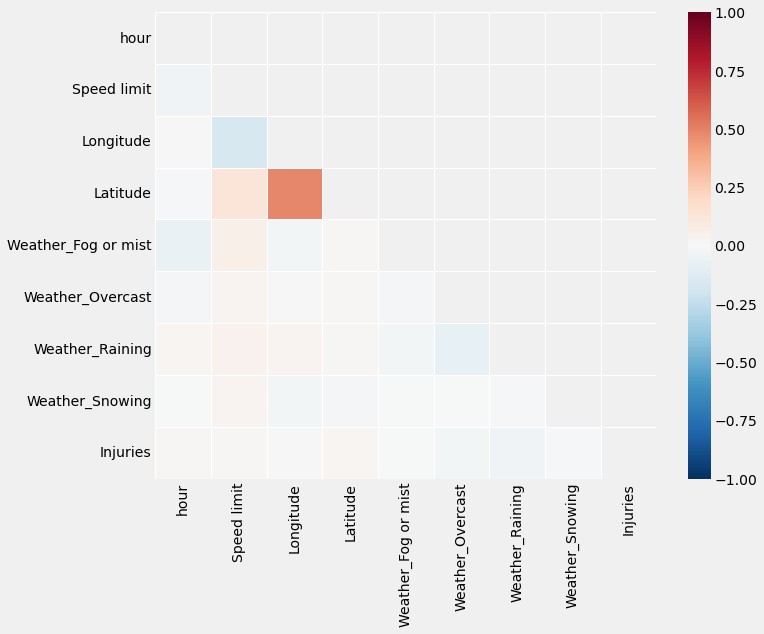

In [53]:
corr_matrix = pd.concat([X, y], axis=1).corr()
print(type(corr_matrix))
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=False, fmt=".1f", vmin=-1,
            vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

In [54]:
print(f'Our model accuracy is {y.sum()/y.count()}')

print(f'Our model error is {1-y.sum()/y.count()}')

Our model accuracy is Injuries    0.691723
dtype: float64
Our model error is Injuries    0.308277
dtype: float64


In [55]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
k_range = list(range(1, 50,2))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector 

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df['Baseline'] = (1-y.sum()/y.count()).Injuries

df.head()

,training error,testing error,Baseline
K,,,
49,0.308277,0.307718,0.308277
47,0.308277,0.308195,0.308277
45,0.308277,0.308673,0.308277
43,0.308277,0.308673,0.308277
41,0.308277,0.308893,0.308277


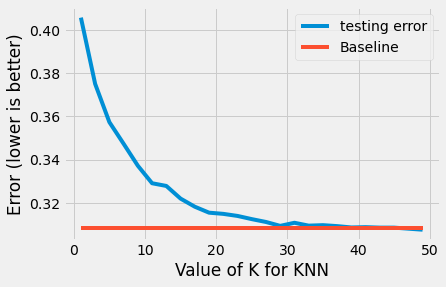

In [58]:

df.plot(y=['testing error', 'Baseline']);
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [59]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)
    
# Calculate training error (error = 1 - accuracy).
y_pred_class = knn.predict(X)
training_accuracy = metrics.accuracy_score(y, y_pred_class)
print(training_accuracy)
# Calculate testing error.
y_pred_class = knn.predict(X_test)
testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(testing_accuracy)

X = crash_model.copy()
y= NSW_crash[['Injuries']]



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.6917227635482005
0.6922087940344561


In [40]:
dataset = pd.DataFrame({'Truth': y_test.Injuries, 'Predicted': y_pred_class}, columns=['Truth', 'Predicted'])
dataset['adHoc'] = 1
dataset.head()
predictive_table = pd.pivot_table(dataset, columns = ['Truth'], index = ['Predicted'], values = 'adHoc', aggfunc= 'count')
print(predictive_table)

Truth         0      1
Predicted             
0           544    557
1          7829  18293
